<center><h1 style="font-size:40px;">Exercise II: Performance</h1></center>

---

# Excercise 2 - Performance

From now on we will talk about *performance*! It can be performance of a trained model on the training dataset or the performance on the validation dataset. What do we mean by performance?  For classification problems we will provide 4 different measurements as returned by a call to the *stats_class* function. They are:
* Sensitivity = fraction of correctly classified "1" cases
* Specificity = fraction of correctly classified "0" cases
* Accuracy = fraction of correctly classified cases
* loss = cross-entropy error (so low loss means good performance!)

A suggestion for you is to either use accuracy or loss as your performance measure.

**Note:** Use a fixed random seed for this exercise since you will compare between runs. 

# Data: syn1 - syn3
Three different synthetic classification problems will be used. They are all 2D binary classification problems which allows for an easy visual inspection of the different classes and the decision boundary implemented by the network. They are called *syn1, syn2* and *syn3*. Each of these datasets are generated "on the fly" each time. They come from various normal distributions. Since they are generated using random numbers it means that each time you generate the data it will be slightly different from next time. You can control this by having a fixed *seed* to the random number generator. The cell "PlotData" will plot these datasets.

## Code

The following code allows us to edit imported files without restarting the kernel for the notebook

In [1]:
%load_ext autoreload
%autoreload 2

# Hacky solution to access the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('')))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl

from config import LabConfig
from dataset import MLPData
from utils.model import Model
from utils.progressbar import LitProgressBar
from utils.model import Model
from torch.utils.data import TensorDataset, DataLoader
from utils import (
    plot,
    progressbar
) 

In [3]:
cfg = LabConfig()

# Defining the MLP model

This cell defines the MLP model. There are a number of parameters that is needed to 
define a model. Here is a list of them: **Note:** They can all be specified when you call
this function in later cells. The ones specified in this cell are the default values.


In [4]:
class MLP(torch.nn.Module):
    def __init__(self, 
                inp_dim=None,         
                hidden_nodes=1,                      # number of nodes in hidden layer
                num_out=None,
                **kwargs
            ):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(inp_dim, hidden_nodes)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_nodes, num_out)


    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        return torch.sigmoid(output)

## Define a function that allow us to convert numpy to pytorch DataLoader

In [5]:
def numpy2Dataloader(x,y, batch_size=25, num_workers=10,**kwargs):
    return DataLoader(
        TensorDataset(
            torch.from_numpy(x).float(), 
            torch.from_numpy(y).unsqueeze(1).float()
        ),
        batch_size=batch_size,
        num_workers=num_workers,
        **kwargs
    )

## Dataset

First we convert our dataset into a pytorch Dataset. Thereafter we load it into our DataLoader. Note that we here define the batch_size and the number of workers that should be used. 

In [6]:
# Generate training data
x_train, d_train = MLPData.syn2(100)
x_val, d_val = MLPData.syn2(1000)

train_loader = numpy2Dataloader(x_train,d_train)
val_loader =  numpy2Dataloader(x_val,d_val)

## Configuration
Setup our local config that should be used for the trainer.

In [7]:
config = {
    'max_epochs':10,
    'model_params':{
        'inp_dim':x_train.shape[1],         
        'hidden_nodes':1,   # activation functions for the hidden layer
        'num_out':1 # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes
    },
    'criterion':torch.nn.BCELoss(), # error function
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.005,
        }
    }
}

## Training

Lastly, put everything together and call on the trainers fit method. 

In [8]:
model = Model(MLP(**config["model_params"]),**config)

trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=cfg.GPU,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[LitProgressBar()],
            progress_bar_refresh_rate=1,
            weights_summary=None, # Can be None, top or full
            num_sanity_val_steps=10,   
        )
trainer.fit(
    model, 
    train_dataloader=train_loader,
    val_dataloaders=val_loader
);

/home/stud/d/denmar20/.conda/envs/deeplearn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
/home/stud/d/denmar20/.conda/envs/deeplearn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:167: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/stud/d/denmar20/.conda/envs/dee

/home/stud/d/denmar20/.conda/envs/deeplearn/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1805: LightningDeprecationWarning: `trainer.progress_bar_dict` is deprecated in v1.5 and will be removed in v1.7. Use `ProgressBarBase.get_metrics` instead.
  rank_zero_deprecation(


## Evaluation


 ########## STATISTICS for Training Data ########## 

Accuracy   0.5
Sensitivity   0.0
Specificity   1.0

 ##################################################

 ########## STATISTICS for Validation Data ########## 

Accuracy   0.5
Sensitivity   0.0
Specificity   1.0

 ##################################################


/home/stud1/d/denmar20/ArtificialFlyingObjects/utils/plot.py:72: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z, cmap=plt.cm.Paired)


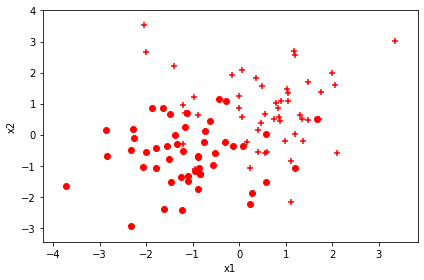

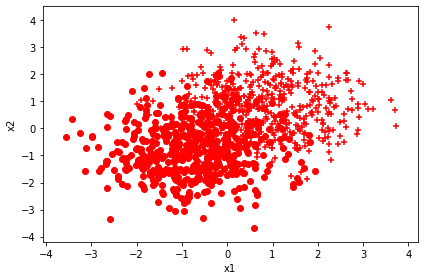

In [9]:
# Call the stats function to print out statistics for classification problems
plot.stats_class(x_train, d_train, 'Training', model)
plot.stats_class(x_val, d_val, 'Validation', model)

# Show the decision boundary for the training dataset
plot.decision_bondary(trainer.lightning_module, x_train, d_train)

# If you uncomment this one you will see how the decsion boundary is with respect to the validation data
plot.decision_bondary(trainer.lightning_module,x_val, d_val)

In [10]:
def model_eval(config_, train_loader_, val_loader_):
    model = Model(MLP(**config_["model_params"]),**config_)

    trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=cfg.GPU,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[LitProgressBar()],
            progress_bar_refresh_rate=1,
            weights_summary=None, # Can be None, top or full
            num_sanity_val_steps=10,   
        )
    trainer.fit(
        model, 
        train_dataloader=train_loader_,
        val_dataloaders=val_loader_
    );
    
    # Call the stats function to print out statistics for classification problems
    plot.stats_class(x_train, d_train, 'Training', model)
    plot.stats_class(x_val, d_val, 'Validation', model)

    # Show the decision boundary for the training dataset
    plot.decision_bondary(trainer.lightning_module, x_train, d_train)

    # If you uncomment this one you will see how the decsion boundary is with respect to the validation data
    plot.decision_bondary(trainer.lightning_module,x_val, d_val)

## Task 1
Train a classifier for the *syn2* dataset. Use the a validation dataset (val_loader) as an estimate of the *true* performance. Since we generate these datasets we can allow for a relatively large validation dataset in order to get a more accurate estimation of *true* performance. The default value in the cell is to generate 1000 validation datapoints. 

Now, use syn2 dataset with 100 training data points and train a *linear* MLP to separate the two classes, i.e. use a single hidden node.

**TODO:** What is the performance you get on the validation dataset?

## Task 2
This task should overtrain the MLP! Increase the number of hidden nodes to get better and better training performance.

**Hint:** Overtraining here often means finding good local minimum of the error function, which may require some tuning of the learning parameters. This means that you may have to change the learning rate, increase the number of epochs and use "better" minimization methods. Even though we have not yet talked about the *Adam* minimization method, it is generally better than vanilla *stochastic gradient descent*. It is therefore used in the cells below as the default minimizer. Also you may want to change the size of the "batch_size" parameter. It is by default using all data.

**TODO:** How many hidden nodes do you need to reach an accuracy >95% on your training dataset?

## Task 3
Now you are going to use the *syn3* dataset. So, use **150** training datapoints from the synthetic dataset 3 and train an MLP to separate the two classes. Also use about 1000 datapoints for validation.

**TODO:** When you overtrained in the previous question, how much much did the validation *loss* increase, compared to the linear model of Task 2?

**TODO:** What is the optimal number of hidden nodes for the syn2 dataset in order to maximize your validation performance?

**TODO:** How many hidden nodes do you need to find a reasonable solution to the problem?  Extra: Can you figure out why this many?

/home/stud/d/denmar20/.conda/envs/deeplearn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
/home/stud/d/denmar20/.conda/envs/deeplearn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:167: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/stud/d/denmar20/.conda/envs/dee

Epoch 10 [4/4] {'loss': '0.647'}
 ########## STATISTICS for Training Data ########## 

Accuracy   0.67
Sensitivity   0.98
Specificity   0.36

 ##################################################

 ########## STATISTICS for Validation Data ########## 

Accuracy   0.7147
Sensitivity   0.9826
Specificity   0.4468

 ##################################################


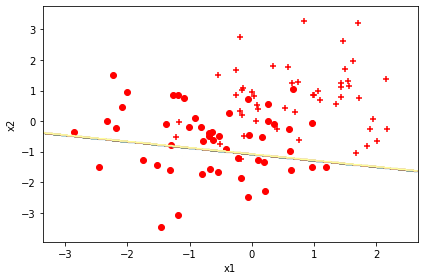

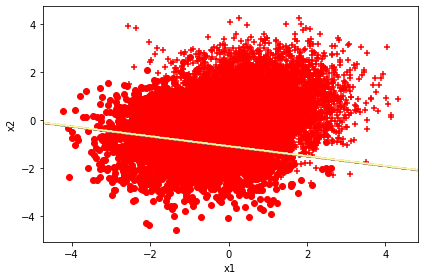

In [11]:
# Task 1 (just copy of previous one, made for better structure)

# Generate training data
x_train, d_train = MLPData.syn2(100)
x_val, d_val = MLPData.syn2(10000) # increased for the sake of experiment

train_loader = numpy2Dataloader(x_train,d_train)
val_loader =  numpy2Dataloader(x_val,d_val)

config = {
    'max_epochs':10,
    'model_params':{
        'inp_dim':x_train.shape[1],         
        'hidden_nodes':1,   # activation functions for the hidden layer
        'num_out':1 # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes
    },
    'criterion':torch.nn.BCELoss(), # error function
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.005,
        }
    }
}

model_eval(config, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 100 [4/4] {'loss': '0.361'}
 ########## STATISTICS for Training Data ########## 

Accuracy   0.83
Sensitivity   0.8
Specificity   0.86

 ##################################################

 ########## STATISTICS for Validation Data ########## 

Accuracy   0.8645
Sensitivity   0.8272
Specificity   0.9018

 ##################################################


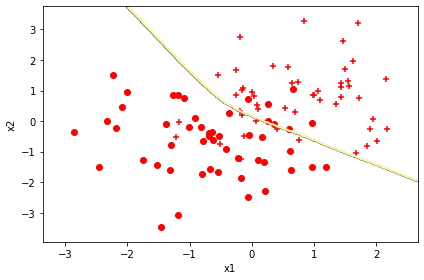

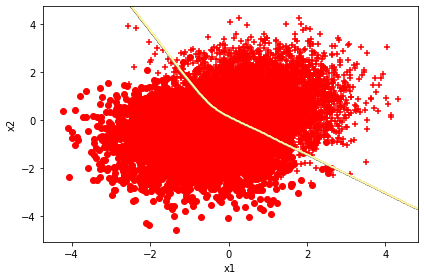

In [12]:
# Task 2

config = {
    'max_epochs':100,
    'model_params':{
        'inp_dim':x_train.shape[1],         
        'hidden_nodes':1000,   # activation functions for the hidden layer
        'num_out':1 # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes
    },
    'criterion':torch.nn.BCELoss(), # error function
    'optimizer':{
        "type":torch.optim.SGD,
        "args":{
            "lr":0.01,
        }
    }
}

model_eval(config, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/stud/d/denmar20/.conda/envs/deeplearn/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:394: UserWarning: The number of training samples (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 100 [6/6] {'loss': '0.293'}
 ########## STATISTICS for Training Data ########## 

Accuracy   0.8866666666666667
Sensitivity   0.96
Specificity   0.74

 ##################################################

 ########## STATISTICS for Validation Data ########## 

Accuracy   0.839
Sensitivity   0.9174174174174174
Specificity   0.6826347305389222

 ##################################################


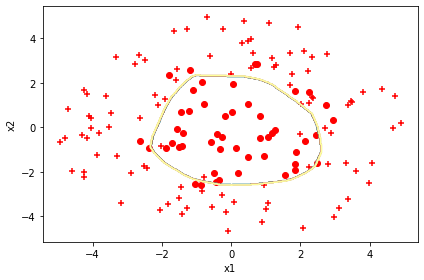

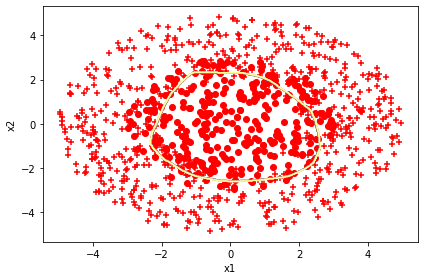

In [13]:
# Task 3

x_train, d_train = MLPData.syn3(150)
x_val, d_val = MLPData.syn3(1000)

train_loader = numpy2Dataloader(x_train,d_train)
val_loader =  numpy2Dataloader(x_val,d_val)

config = {
    'max_epochs':100,
    'model_params':{
        'inp_dim':x_train.shape[1],         
        'hidden_nodes':50,   # activation functions for the hidden layer
        'num_out':1 # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes
    },
    'criterion':torch.nn.BCELoss(), # error function
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.005,
        }
    }
}

model_eval(config, train_loader, val_loader)